In [1]:
import csv
import numpy as np
import tensorflow as tf
import keras
import cv2
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
# Define a function for loading images and steering angles
def preprocess_img(image):
    # Crop the top 50 pixes
    img = image[50:, :, :]
    # Resize to 200*66
    img = cv2.resize(img, (200, 66))
    return img

def load_data(data):
    '''
    Get the images and the steering angles
    Params:
    data: the folder where images and logfile are stored
    The the first line of the logfile consists of names. All the rest lines consist of the locations of images, 
    steering angles, and other data. To load the images and steering angles, the first line is omitted.
    '''
    images = []
    steers = []
    loc = data + '/driving_log.csv'
    with open(loc) as csvfile:
        reader = csv.reader(csvfile)
        i = 0 # This count is for omitting the first line of the logfile
        for line in reader:
        # Skip the header 
            if i > 0:
                # First, get the image name for the middle, left, right cameras
                path_mid = line[0].split('/')[-1]
                path_left = line[1].split('/')[-1]
                path_right = line[2].split('/')[-1]
                # Second, get the image path
                img_path_mid = data + '/IMG/' + path_mid
                img_path_left = data + '/IMG/' + path_left
                img_path_right = data + '/IMG/' + path_right
                # Third, load the images 
                # cv2 loads images as BGR, convert to RGB
                img = cv2.imread(img_path_mid)[:, :, ::-1]
                img = preprocess_img(img)
                img_left = cv2.imread(img_path_left)[:, :, ::-1]
                img_left = preprocess_img(img_left)
                img_right = cv2.imread(img_path_right)[:, :, ::-1]
                img_right = preprocess_img(img_right)
                # Finally, append all images and corresponding steering angles into lists. 
                # Left and right camera images are there for steering cars to the middle, 0.5 is chosen for correction
                images.append(img)
                steers.append(float(line[3]))
                images.append(img_left)
                steers.append(0.9)
                images.append(img_right)
                steers.append(-0.9)
                # Flip the middle images 
                img2 = np.fliplr(img)
                images.append(img2)
                steers.append(-float(line[3]))
            i += 1
    return images, steers

In [3]:
# shuffle the images and split into training and validation sets
def train_valid_split(images, steers, valid_size = 0.05):
    ind = np.arange(len(images))
    np.random.seed(42)
    np.random.shuffle(ind)
    cutoff = int(len(ind)*(1-valid_size))
    train_ind = ind[:cutoff]
    valid_ind = ind[cutoff:]
    train_images = [images[i] for i in train_ind]
    valid_images = [images[i] for i in valid_ind]
    train_steers = [steers[i] for i in train_ind]
    valid_steers = [steers[i] for i in valid_ind]
    return train_images, train_steers, valid_images, valid_steers

# Define a generator for memory saving. Put the generator into a while loop to avoid running out of data during training
def generator_(X, y, batch_size = 64):
    while True:
        for offset in range(0, len(X), batch_size):
            end = offset + batch_size
            X_batch = np.array(X[offset:end])
            y_batch = np.array(y[offset:end])
            yield X_batch, y_batch

In [4]:
def trim_data(images, steers, nb_bins=40, cutoff=2000):
    """Make the training data distribution less steep by discarding some data
    
    Params: 
    nb_bins: the number of bins for counting steers angles
    cutoff: the value threshold, if a steering angle has more samples than it, then remove part of the data
    
    Return: trimmed images and steering angles
    """
    hist, bins = np.histogram(steers, bins=np.linspace(-1,1, nb_bins))
    # Find the bins that need to discard some data
    bin_ind_to_remove = [i for i in range(len(hist)) if hist[i]>cutoff]

    # Calculate the probability to keep for the selected bins. 
    # The prob equals the average adjacent bin counts divided by the real counts of the bin
    keep_prob = [(hist[i-1]+hist[i+1])/(2*hist[i]) for i in bin_ind_to_remove]

    # Create an index for data deletion
    index2delete = []
    for i in range(len(steers)):
        for j in bin_ind_to_remove:
            if steers[i] > bins[j] and steers[i] <= bins[j+1]:
                if np.random.random() > keep_prob[bin_ind_to_remove.index(j)]:
                    index2delete.append(i)
    images = [images[i] for i in range(len(images)) if i not in index2delete]
    steers = [steers[i] for i in range(len(steers)) if i not in index2delete]
#     print('{} hist in {} bins'.format(len(hist), len(bins)))
#     print('')
#     print('The trimmed steering angles are in bins: {}'.format([(bins[i], bins[i+1]) for i in bin_ind_to_remove]),
#           'The respective keep probabilities are: {}'.format(keep_prob))
    return images, steers

In [6]:
# Get the images and steering angle data
images, steers = [], []
image, steer = load_data('./data')
images.extend(image)
steers.extend(steer)
    

In [7]:
trimmed_images, trimmed_steers = trim_data(images, steers) 

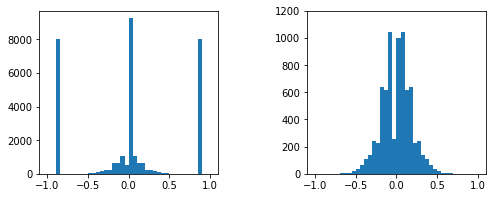

In [9]:
# Visualize the steering angles distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].hist(steers, bins=40)
# axes[0].set_ylim(0, 5000)
axes[1].hist(trimmed_steers,bins=40)
axes[1].set_ylim(0, 1200)
plt.subplots_adjust(wspace=0.5)

plt.show()
fig.savefig('Data_distribution.png', dpi=300)

In [33]:
# Split the data into training and validation sets
train_images, train_steers, valid_images, valid_steers = train_valid_split(trimmed_images, trimmed_steers)

In [34]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.layers import Convolution2D, Lambda, Cropping2D
from keras.layers import Dropout

In [35]:
# The model is similar with the model from Nvidia paper: Nvidia_X End-to-End Deep Learning for Self-Driving Cars
model = Sequential()

#input image size is 160*320*3
model.add(Lambda(lambda x: x/127.5-1, input_shape=images[0].shape))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), border_mode='valid', activation='elu'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), border_mode='valid', activation='elu'))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), border_mode='valid', activation='elu'))
model.add(Convolution2D(64, 3, 3, activation='elu'))
model.add(Convolution2D(64, 3, 3, activation='elu'))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer=keras.optimizers.adam(lr=0.0001))
hist = model.fit_generator(generator_(train_images, train_steers), samples_per_epoch=len(train_images), 
       validation_data = generator_(valid_images, valid_steers), nb_val_samples = len(valid_images), nb_epoch=10)
model.save('model.h5')
with open('./model.json' ,'w') as f:
    f.write(model.to_json())

Epoch 1/10
7164/7164 [==============================] - 6s - loss: 0.0442 - val_loss: 0.0270
Epoch 2/10
7164/7164 [==============================] - 6s - loss: 0.0301 - val_loss: 0.0247
Epoch 3/10
7164/7164 [==============================] - 6s - loss: 0.0247 - val_loss: 0.0230
Epoch 4/10
7164/7164 [==============================] - 6s - loss: 0.0222 - val_loss: 0.0220
Epoch 5/10
7164/7164 [==============================] - 6s - loss: 0.0204 - val_loss: 0.0213
Epoch 6/10
7164/7164 [==============================] - 6s - loss: 0.0196 - val_loss: 0.0207
Epoch 7/10
7164/7164 [==============================] - 6s - loss: 0.0185 - val_loss: 0.0201
Epoch 8/10
7164/7164 [==============================] - 6s - loss: 0.0175 - val_loss: 0.0201
Epoch 9/10
7164/7164 [==============================] - 6s - loss: 0.0169 - val_loss: 0.0197
Epoch 10/10
7164/7164 [==============================] - 6s - loss: 0.0168 - val_loss: 0.0196
